<a href="https://colab.research.google.com/github/Andriamaharorado/datascience/blob/main/CV_Classification_Organique_Recyclable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification d'images des produits organique et recyclable

## Objectif
L'objectif de ce projet est de classifier les éléments organiques qui sont biodégradables et les éléments recyclables tels que les plastiques et les ferrailles. Nous avons utilisé des datasets disponibles sur Kaggle pour affiner notre modèle de classification d'images.
## Contexte
Antananarivo, la capitale de Madagascar, fait face à des défis importants en matière de gestion des déchets. Bien que certaines startups et villes, comme la commune d'Alasora, aient commencé à trier les déchets, dans les décharges urbaines, les déchets ne sont pas triés et sont directement envoyés à la décharge d'Andralanitra. Cette dernière est devenue la "13ème colline" d'Antananarivo en raison de l'accumulation croissante des déchets, formant ainsi une colline. La population environnante d'Andralanitra est suffoquée par l'odeur nauséabonde des déchets, entraînant des maladies chroniques.

En réalisant ce projet, nous visons à encourager le tri des déchets. Les déchets organiques pourraient être transformés en compost et en source de gaz, tandis que les déchets recyclables deviendraient plus faciles à gérer, améliorant ainsi le cycle de transformation.

## Dataset
Dans ce dataset de Kaggle <a href="https://www.kaggle.com/datasets/techsash/waste-classification-data">Waste Classification data</a>, nous disposons de deux classes avec plus de 20 000 images au total.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
class WasteDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 1], self.labels_df.iloc[idx, 0] + '.jpg')
        try:
            image = Image.open(img_name).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"File not found: {img_name}")

        label = 0 if self.labels_df.iloc[idx, 1] == 'Recyclable' else 1

        if self.transform:
            image = self.transform(image)

        return image, label

"data_transforms" définit un ensemble de transformations à appliquer aux images avant de les utiliser pour entraîner. Ces transformations sont essentielles pour améliorer les performances et la robustesse du modèle.

In [ ]:
# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256 pixels
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with mean and std
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256 pixels
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with mean and std
    ]),
}

In [ ]:
# Definir les chemins
dataset_path = '/content/drive/MyDrive/datasetwastedetection/DATASET'
csv_train_path = '/content/drive/MyDrive/datasetwastedetection/DATASET/train_labels.csv'
csv_test_path = '/content/drive/MyDrive/datasetwastedetection/DATASET/test_labels.csv'
root_dir_train = '/content/drive/MyDrive/datasetwastedetection/DATASET/TRAIN'
root_dir_test = '/content/drive/MyDrive/datasetwastedetection/DATASET/TEST'

In [ ]:
# Créer le jeu de données complet pour l'entraînement
full_train_dataset = WasteDataset(csv_file=csv_train_path, root_dir=root_dir_train, transform=data_transforms['train'])

La donnée de validation va représenter 20% du donnée d'entrainement.

In [ ]:
# Diviser les indices pour l'entraînement et la validation
dataset_size = len(full_train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
# Créer des échantillonneurs (samplers)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
# Créer les chargeurs de données (data loaders)
train_loader = DataLoader(full_train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(full_train_dataset, batch_size=32, sampler=val_sampler, num_workers=2)

In [ ]:
# Créer le jeu de données de test et le chargeur de test
test_dataset = WasteDataset(csv_file=csv_test_path, root_dir=root_dir_test, transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

## Resnet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
# Définir le modèle ResNet18 pré-entraîné
num_classes = 2  # Nombre de classes (Recyclable et Organique)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [ ]:
# Détection du dispositif (GPU ou CPU) et transfert du modèle sur le dispositif approprié
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, log_interval=100):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        if batch_idx % log_interval == 0:
            print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Loss: {epoch_loss:.4f}")

In [ ]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

La fonction "train_and_validate" fait l'entrainement du model ainsi que la validation apres avoir fini l'entrainement qui fait appel à la fonction "train_one_epoch" et à la fonction "validate_model". Le model est ensuite sauvegarder vers un chemin défini.

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device,model_path, num_epochs=10, log_interval=100):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_one_epoch(model, train_loader, criterion, optimizer, device, log_interval)

    validate_model(model, val_loader, criterion, device)
    # Sauvegarde du modèle
    torch.save(model.state_dict(), model_path)
    print(f"Modèle sauvegardé sous '{model_path}'")

### Adam
Dans le premier cas, nous allons choisir l'optimiseur "Adam". La convergence de cet optimiseur est rapide et il est robuste

In [ ]:
# Définir la fonction de perte
criterion = nn.CrossEntropyLoss()

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Appel de la fonction d'entraînement et de validation
train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, '/content/drive/MyDrive/models/modelresnet18versusSec.pth')

Epoch 1/10
Batch 0/568, Loss: 0.2312
Batch 100/568, Loss: 0.2264
Batch 200/568, Loss: 0.2767
Batch 300/568, Loss: 0.2234
Batch 400/568, Loss: 0.3824
Batch 500/568, Loss: 0.4301
Loss: 0.2044
Epoch 2/10
Batch 0/568, Loss: 0.3133
Batch 100/568, Loss: 0.1636
Batch 200/568, Loss: 0.2190
Batch 300/568, Loss: 0.2422
Batch 400/568, Loss: 0.1503
Batch 500/568, Loss: 0.2874
Loss: 0.1861
Epoch 3/10
Batch 0/568, Loss: 0.2961
Batch 100/568, Loss: 0.1962
Batch 200/568, Loss: 0.0772
Batch 300/568, Loss: 0.2120
Batch 400/568, Loss: 0.3141
Batch 500/568, Loss: 0.2240
Loss: 0.1736
Epoch 4/10
Batch 0/568, Loss: 0.1170
Batch 100/568, Loss: 0.1188
Batch 200/568, Loss: 0.2715
Batch 300/568, Loss: 0.1363
Batch 400/568, Loss: 0.1736
Batch 500/568, Loss: 0.1039
Loss: 0.1598
Epoch 5/10
Batch 0/568, Loss: 0.1575
Batch 100/568, Loss: 0.1346
Batch 200/568, Loss: 0.3040
Batch 300/568, Loss: 0.3481
Batch 400/568, Loss: 0.5115
Batch 500/568, Loss: 0.4839
Loss: 0.1498
Epoch 6/10
Batch 0/568, Loss: 0.1498
Batch 100/568

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

La fonction "evaluate_model" permet d'évaluer les performances du modèle entraîné en retournant les métriques de classification. Elle offre une vue d'ensemble précise de la qualité du modèle en termes de précision, rappel, et f1-score, tout en visualisant la matrice de confusion. Cette fonction fournit ainsi une perception claire des forces et faiblesses du modèle, en facilitant l'analyse des résultats obtenus.

In [ ]:
def evaluate_model(model_path, test_loader, save_image_name, image_title):
    # Charger le modèle sauvegardé
    model = models.resnet18()  # Remplacez par l'architecture de votre modèle
    model.fc = nn.Linear(model.fc.in_features, 2)  # Adapter la dernière couche si nécessaire

    # Charger les poids sauvegardés
    model.load_state_dict(torch.load(model_path))

    # Déplacer le modèle sur le GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Évaluation du modèle
    model.eval()
    with torch.no_grad():
        test_preds = []
        test_labels = []
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Déplacer les entrées vers le GPU
            labels = labels.to(device)  # Déplacer les labels vers le GPU si nécessaire

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU pour les convertir en numpy
            test_labels.extend(labels.cpu().numpy())  # Déplacer les labels vers le CPU pour les convertir en numpy

    # Évaluation des performances
    print("Classification Report:")
    print(classification_report(test_labels, test_preds))

    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(test_labels, test_preds)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Recyclable', 'Organique'],
                yticklabels=['Recyclable', 'Organique'])
    plt.xlabel('Prédictions')
    plt.ylabel('Véritables')
    plt.title(image_title)

    # Enregistrement de l'image
    plt.savefig(f'/content/drive/MyDrive/{save_image_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1112
           1       0.91      0.99      0.95      1411

    accuracy                           0.94      2523
   macro avg       0.95      0.93      0.94      2523
weighted avg       0.94      0.94      0.94      2523



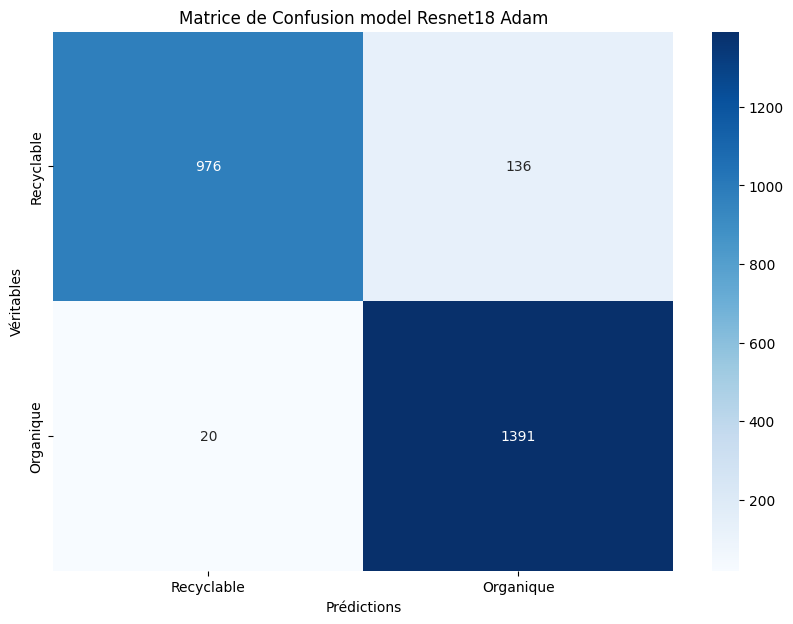

In [ ]:
model_path = '/content/drive/MyDrive/models/modelresnet18AdamversusSec.pth'
save_image_name = 'matrice_confusion_AdamResnet18'
image_title = 'Matrice de Confusion model Resnet18 Adam'

evaluate_model(model_path, test_loader, save_image_name, image_title)

### SGD
L'optimiseur Stochastic Gradient Descent est pratique pour la généralisation.

In [ ]:
# Définir la fonction de perte
criterion = nn.CrossEntropyLoss()

# Définir l'optimiseur
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Appel de la fonction d'entraînement et de validation
train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, '/content/drive/MyDrive/models/modelresnet18SGDversusSec.pth')

Epoch 1/10
Batch 0/568, Loss: 1.0742
Batch 100/568, Loss: 0.1041
Batch 200/568, Loss: 0.0842
Batch 300/568, Loss: 0.1177
Batch 400/568, Loss: 0.1444
Batch 500/568, Loss: 0.0676
Loss: 0.1550
Epoch 2/10
Batch 0/568, Loss: 0.3791
Batch 100/568, Loss: 0.1804
Batch 200/568, Loss: 0.0430
Batch 300/568, Loss: 0.0870
Batch 400/568, Loss: 0.1503
Batch 500/568, Loss: 0.1043
Loss: 0.0983
Epoch 3/10
Batch 0/568, Loss: 0.0560
Batch 100/568, Loss: 0.0513
Batch 200/568, Loss: 0.1658
Batch 300/568, Loss: 0.1134
Batch 400/568, Loss: 0.0869
Batch 500/568, Loss: 0.0372
Loss: 0.0725
Epoch 4/10
Batch 0/568, Loss: 0.0348
Batch 100/568, Loss: 0.0153
Batch 200/568, Loss: 0.0227
Batch 300/568, Loss: 0.0329
Batch 400/568, Loss: 0.2090
Batch 500/568, Loss: 0.0133
Loss: 0.0543
Epoch 5/10
Batch 0/568, Loss: 0.0062
Batch 100/568, Loss: 0.0794
Batch 200/568, Loss: 0.0806
Batch 300/568, Loss: 0.3011
Batch 400/568, Loss: 0.0655
Batch 500/568, Loss: 0.1020
Loss: 0.0407
Epoch 6/10
Batch 0/568, Loss: 0.0277
Batch 100/568

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1112
           1       0.88      0.99      0.94      1411

    accuracy                           0.92      2523
   macro avg       0.94      0.91      0.92      2523
weighted avg       0.93      0.92      0.92      2523



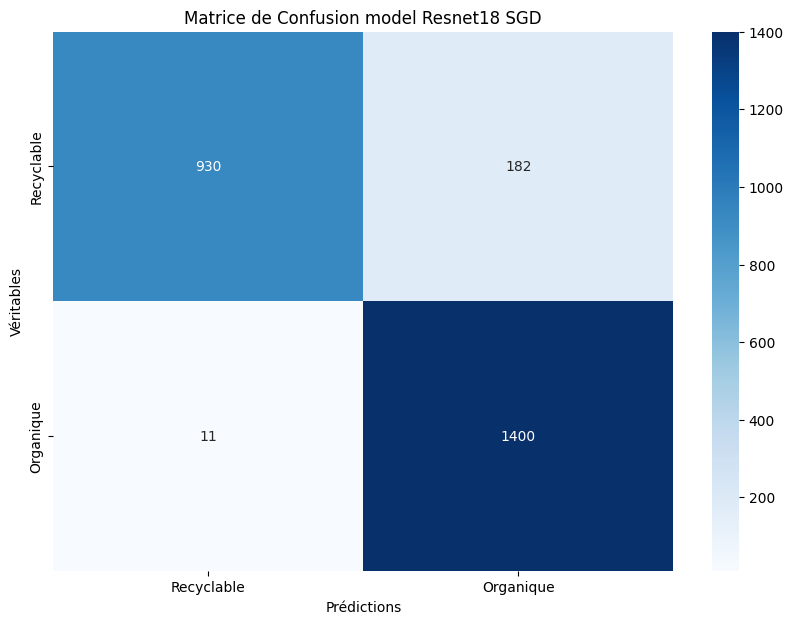

In [ ]:
model_path = '/content/drive/MyDrive/models/modelresnet18SGDversusSec.pth'
save_image_name = 'matrice_confusion_SGDResnet18'
image_title = 'Matrice de Confusion model Resnet18 SGD'

evaluate_model(model_path, test_loader, save_image_name, image_title)

Les résultats du matrice de confusion et les metrics montrent que Adam est plus performant pour classer les produits recyclables, tandis que SGD est plus efficace pour les produits organiques. Cela pourrait être dû au fait que SGD, avec son processus de mise à jour plus rigoureux, permet une meilleure généralisation pour certains types de données. En revanche, Adam, avec son taux d'apprentissage adaptatif, a montré une meilleure précision sur la classe "Recyclable" mais a été légèrement moins performant sur la classe "Organique". \
Adam est choisi pour la suite de ce projet, car la classification des matériaux recyclables est plus cruciale dans la gestion des déchets.

## Inception

Le principe du model Inception est de meme que pour le resnet. La difference entre les deux modeles dans notre code est la transformation.

In [ ]:
# Définir les transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),  # Taille d'entrée requise par Inception v3
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),  # Taille d'entrée requise par Inception v3
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Créer le dataset complet
full_train_dataset = WasteDataset(csv_file=csv_train_path, root_dir=root_dir_train, transform=data_transforms['train'])

# Diviser les indices pour l'entraînement et la validation
dataset_size = len(full_train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Créer les samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Créer les DataLoaders
train_loader = DataLoader(full_train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(full_train_dataset, batch_size=32, sampler=val_sampler, num_workers=2)

In [ ]:
# Charger le modèle Inception v3 pré-entraîné
model = models.inception_v3(pretrained=True)

# Adapter la dernière couche pour votre nombre de classes
num_classes = 2  # Changez selon votre dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Utiliser le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 157MB/s] 


In [ ]:
# Définir la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10  # Nombre d'époques pour l'entraînement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

torch.save(model.state_dict(), '/content/drive/MyDrive/models/modelInceptionAdam.pth')
print("Modèle sauvegardé sous 'modelInceptionAdam.pth'")

Epoch 1/10, Loss: 0.4761336429280714
Epoch 2/10, Loss: 0.39265585264427144
Epoch 3/10, Loss: 0.3567599300163942
Epoch 4/10, Loss: 0.33254308496195245
Epoch 5/10, Loss: 0.3020505173079355
Epoch 6/10, Loss: 0.2827398125344599
Epoch 7/10, Loss: 0.29978554524009077
Epoch 8/10, Loss: 0.2722955799832101
Epoch 9/10, Loss: 0.24598451632953866
Epoch 10/10, Loss: 0.22587798598130615
Accuracy: 92.7769213829553%
Modèle sauvegardé sous 'modelVgg16Adam.pth'


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.48      0.64      1112
           1       0.71      0.99      0.82      1411

    accuracy                           0.76      2523
   macro avg       0.84      0.73      0.73      2523
weighted avg       0.82      0.76      0.74      2523



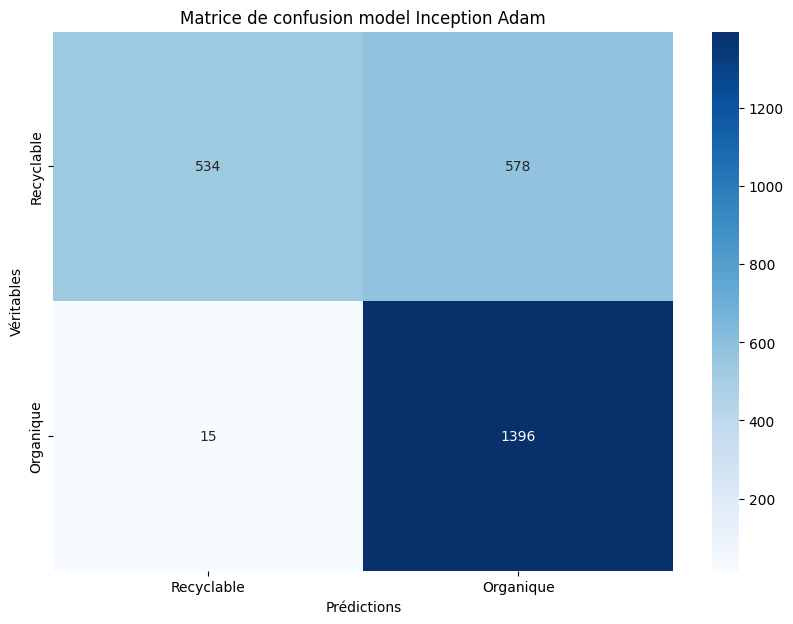

In [ ]:
model = models.inception_v3(init_weights=True)  # Remplacez par l'architecture de votre modèle
# Adapter la dernière couche pour correspondre au nombre de classes de votre tâche (par exemple, 2 classes)
model.fc = nn.Linear(model.fc.in_features, 2)

# Charger les poids sauvegardés
model.load_state_dict(torch.load('/content/drive/MyDrive/models/modelInceptionAdam.pth'))

# Déplacer le modèle sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Évaluation du modèle
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Déplacer les entrées vers le GPU
        labels = labels.to(device)  # Déplacer les labels vers le GPU si nécessaire

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU pour les convertir en numpy
        test_labels.extend(labels.cpu().numpy())  # Déplacer les labels vers le CPU pour les convertir en numpy

# Évaluation des performances
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(test_labels, test_preds)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Recyclable', 'Organique'],
            yticklabels=['Recyclable', 'Organique'])
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de confusion model Inception Adam')

# Enregistrement de l'image
plt.savefig('/content/drive/MyDrive/matriceconfusionInception.png', dpi=300, bbox_inches='tight')
plt.show()

#### Receiver Operating Characteristic (ROC)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
def plot_roc_curve(model, test_loader, device, model_name, model_path,save_image_name):
    # Choisir l'architecture du modèle en fonction du nom
    if model_name == "resnet18":
        model = models.resnet18()  # Remplacer par False si vous ne souhaitez pas utiliser les poids pré-entraînés
        model.fc = nn.Linear(model.fc.in_features, 2)  # Adapter la dernière couche pour deux classes
    # Ajoutez d'autres architectures si nécessaire ici
    else:
        raise ValueError(f"Modèle {model_name} non supporté.")

    # Charger les poids sauvegardés
    model.load_state_dict(torch.load(model_path))

    # Déplacer le modèle sur le GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Mettre le modèle en mode évaluation
    model.eval()

    # Prédictions des probabilités sur le jeu de test
    test_probs = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)  # Calculer les probabilités des classes
            test_probs.extend(probs[:, 1].cpu().numpy())  # Probabilité pour la classe 1
            test_labels.extend(labels.cpu().numpy())

    # Calcul des courbes ROC et de l'AUC
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title(f'Courbe ROC du modèle {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'/content/drive/MyDrive/{save_image_name}.png', dpi=300, bbox_inches='tight')
    plt.show()


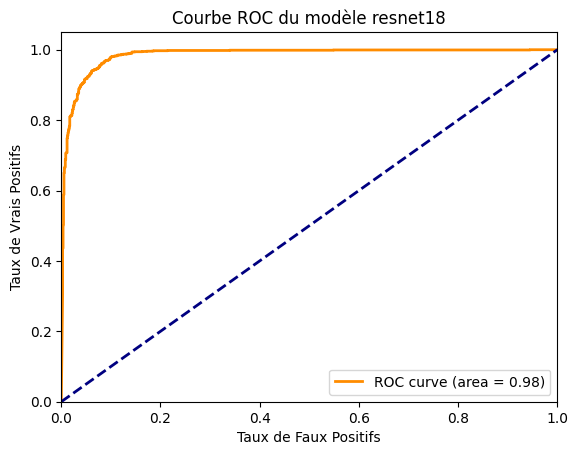

In [ ]:
# Exemple d'utilisation avec le modèle ResNet18 entraîné avec Adam :
model_path='/content/drive/MyDrive/models/modelresnet18AdamversusSec.pth'
model_name="resnet18"
save_image_name="Courbe Roc Resnet18 Adam"
plot_roc_curve(model, test_loader, device, model_name, model_path, save_image_name)

Nous avons un AUC presque parfait Une AUC de 0.98 ce qui signifie que le modèle a une excellente capacité de discrimination entre les deux classes.

### Analyse d'erreur

In [ ]:
model.eval()
# Assuming `model` is your trained model and `val_loader` is your validation dataloader
all_preds = []
all_labels = []
all_images = []
all_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_images = np.array(all_images)
all_probs = np.array(all_probs)

# Calculate errors
errors = all_preds != all_labels

# Only keep the probabilities for incorrect predictions
incorrect_probs = all_probs[errors]
incorrect_preds = all_preds[errors]
incorrect_labels = all_labels[errors]

# Calculate the confidence for incorrect predictions (max probability for the predicted class)
confidence = np.max(incorrect_probs, axis=1)

# Sort indices by confidence in descending order
sorted_indices = np.argsort(confidence)[::-1]

# Sort data based on the sorted indices
worst_case_images = all_images[errors][sorted_indices]
worst_case_preds = incorrect_preds[sorted_indices]
worst_case_labels = incorrect_labels[sorted_indices]
worst_case_confidence = confidence[sorted_indices]

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, class_idx):
        self.model.zero_grad()
        output = self.model(input_image)
        loss = output[0, class_idx]
        loss.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_image.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:
def preprocess_image(img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(img).unsqueeze(0)

def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

In [ ]:
# Instantiate Grad-CAM
target_layer = model.layer4[1].conv2
grad_cam = GradCAM(model, target_layer)

In [ ]:
import cv2
# Define the class-to-index mapping externally
# Définir le mapping manuel
class_to_idx = {'Recyclable': 0, 'Organique': 1}
idx_to_class = {0: 'Recyclable', 1: 'Organique'}

# Visualize the 10 worst-case predictions with Grad-CAM
for i in range(100):
    img = worst_case_images[i].transpose((1, 2, 0))  # Convert to HWC format for visualization
    input_image = preprocess_image(img).to(device)  # Preprocess and move to the same device as the model
    class_idx = worst_case_preds[i]

    # Generate Grad-CAM
    cam = grad_cam.generate_cam(input_image, class_idx)

    # Denormalize the image
    img = denormalize(img)

    # Create a color map for Grad-CAM
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(img)
    cam = 255 * cam / np.max(cam)

    # Plot original image and Grad-CAM
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title(f'Original Image\nPredicted: {idx_to_class[worst_case_preds[i]]}\nActual: {idx_to_class[worst_case_labels[i]]}')
    plt.imshow(img)
    plt.axis('off')

    # Grad-CAM
    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM')
    plt.imshow(cam / 255)
    plt.axis('off')
    plt.savefig('/content/drive/MyDrive/gradcam.png', dpi=300, bbox_inches='tight')
    plt.show()

## Conclusion

Pour ce projet, nous avons utilisé le modèle ResNet18 avec les optimiseurs Adam et SGD, tous deux très couramment utilisés en raison de leurs avantages respectifs. Un modèle Inception a également été employé pour observer les variations, mais le ResNet18 s'est révélé bien plus performant.

L'un des principaux obstacles rencontrés dans ce projet est que les images d'entraînement ne représentent pas bien les fruits et légumes pourris. De plus, la classification binaire s'est avérée trop généralisée, car chaque type de matériau suit un processus de recyclage différent. Le projet ayant un délai de deux semaines, ces obstacles n'ont pas pu être résolus dans les temps impartis. Cependant, nous avons réussi à obtenir un modèle capable de classifier les produits organiques et recyclables. Pour le choix de l'optimiseur, le choix a été balancé d'Adam car il arrive a classifier mieux les produits recyclables. Le perspective pour ce projet est d'améliorer le dataset en rajoutant les sous classes et fait appel aux détection d'objet.

# Résumé


| Modèle          | Architecture          | Nombre de Classes | Méthode d'Optimisation | Accuracy (%) | Précision (%) | Rappel (%) |
|-----------------|-----------------------|-------------------|------------------------|--------------|---------------|------------|
| Inception v3    | Inception v3           | 2                 | Adam                   | 92.7         | 84.0          | 73.0       |
| ResNet18        | ResNet                 | 2                 | SGD                    | 94.0         | 95.0          | 93.0       |
| ResNet18           | Resnet                    | 2                 | Adam                   | 94.0         | 91.0          | 92.0       |
